<a href="https://colab.research.google.com/github/JayeonKangNature/Bachelor_Project_Thesis_2023/blob/main/TIDE_Main_Faster_RCNN_Medical_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/BSc_Project/Main_code_folder/TIMOTHY/preds_df_faster_medical.csv")
preds_df = data

In [ ]:
print(data)

     Unnamed: 0  pred_id  image_id  label_id        xmin        ymin  \
0             0        0         1         1   81.019051  118.619362   
1             1        1         2         1  211.590256  128.473343   
2             2        2         2         1  176.756439  141.900314   
3             3        3         2         1  436.286530  109.935310   
4             4        4         3         1  155.735779  149.703842   
..          ...      ...       ...       ...         ...         ...   
714         714      714       299         1  361.220520  241.604340   
715         715      715       300         1  492.387543  194.344894   
716         716      716       300         1   42.623508  130.484741   
717         717      717       300         1  204.823456   37.226707   
718         718      718       300         1  357.373169  146.806686   

           xmax        ymax     score  
0    339.983803  336.566750  0.563002  
1    445.292389  429.909988  0.563002  
2    383.872955

In [ ]:
def result_cocoform_dict(preds_df):

  results = []

  for n in range(len(preds_df)):
    dictionary = {}
    dictionary['image_id'] = int(preds_df['image_id'][n])
    dictionary['category_id'] = int(preds_df['label_id'][n])
    xmin = float(preds_df['xmin'][n])
    ymin = float(preds_df['ymin'][n])
    xmax = float(preds_df['xmax'][n])
    ymax = float(preds_df['ymax'][n])
    dictionary['bbox'] = [xmin,ymin,abs(xmin-xmax),abs(ymin-ymax)]
    dictionary['score'] = float(preds_df['score'][n])
    results.append(dictionary)

  return results

In [ ]:
pred_df_coco = result_cocoform_dict(data)

In [ ]:
print(pred_df_coco)

[{'image_id': 1, 'category_id': 1, 'bbox': [81.01905059814453, 118.6193618774414, 258.9647521972656, 217.9473876953125], 'score': 0.5630017518997192}, {'image_id': 2, 'category_id': 1, 'bbox': [211.5902557373047, 128.4733428955078, 233.70213317871094, 301.4366455078125], 'score': 0.5630017518997192}, {'image_id': 2, 'category_id': 1, 'bbox': [176.75643920898438, 141.9003143310547, 207.11651611328125, 121.40403747558594], 'score': 0.5630017518997192}, {'image_id': 2, 'category_id': 1, 'bbox': [436.2865295410156, 109.93531036376952, 80.86941528320312, 175.04769897460938], 'score': 0.5630017518997192}, {'image_id': 3, 'category_id': 1, 'bbox': [155.73577880859375, 149.70384216308594, 188.57559204101562, 195.64183044433594], 'score': 0.5630017518997192}, {'image_id': 3, 'category_id': 1, 'bbox': [56.1945915222168, 0.0, 488.95965576171875, 339.1469116210937], 'score': 0.5630017518997192}, {'image_id': 3, 'category_id': 1, 'bbox': [60.24925994873047, 32.63706588745117, 234.0133056640625, 142

In [ ]:
import json

with open('Medical_faster_RCNN_val300.json', 'w') as f:
    json.dump(pred_df_coco, f)

##여기서부턴 원래 타이드

In [ ]:
!pip3 install tidecv
!pip install image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tidecv.data import Data

import zipfile
from pathlib import Path
from appdirs import user_data_dir
import urllib.request
from collections import defaultdict
import shutil
import json
import os

def default_name(path:str) -> str:
	return os.path.splitext(os.path.basename(path))[0]

def get_tide_path():
	if 'TIDE_PATH' in os.environ:
		tide_path = os.environ['TIDE_PATH']
	else:
		tide_path = user_data_dir('tidecv', appauthor=False)

	if not os.path.exists(tide_path):
		os.makedirs(tide_path)

	return tide_path




def COCO(path:str=None, name:str=None, year:int=2017, ann_set:str='val', force_download:bool=False) -> Data:
	"""
	Loads ground truth from a COCO-style annotation file.

	If path is not specified, this will download the COCO annotations for the year and ann_set specified.
	Valid years are 2014, 2017 and valid ann_sets are 'val' and 'train'.
	"""
	if path is None:
		path = download_annotations(
			'COCO{}'.format(year),
			'http://images.cocodataset.org/annotations/annotations_trainval{}.zip'.format(year),
			force_download)

		path = os.path.join(path, 'annotations', 'instances_{}{}.json'.format(ann_set, year))

	if name is None: name = default_name(path)

	with open(path, 'r') as json_file:
		cocojson = json.load(json_file)

	images = cocojson['images']
	anns   = cocojson['annotations']
	cats   = cocojson['categories'] if 'categories' in cocojson else None


	# Add everything from the coco json into our data structure
	data = Data(name, max_dets=100)

	image_lookup = {}

	for idx, image in enumerate(images):
		image_lookup[image['id']] = image
		data.add_image(image['id'], image['file_name'])

	if cats is not None:
		for cat in cats:
			data.add_class(cat['id'], cat['name'])

	for ann in anns:
		image  = ann['image_id']
		_class = ann['category_id']
		box    = ann['bbox']
		# mask   = f.toRLE(ann['segmentation'], image_lookup[image]['width'], image_lookup[image]['height'])

		if ann['iscrowd']: data.add_ignore_region(image, _class, box)
		else:              data.add_ground_truth (image, _class, box)

	return data


In [ ]:
# Import the TIDE evaluation toolkit
from tidecv import TIDE

# Import the datasets we want to use
import tidecv.datasets as datasets


In [ ]:
import json

with open('/content/drive/MyDrive/BSc_Project/Main_code_folder/TIMOTHY/faster_rcnn_prediction_result_coco.json','r') as f:
  faster_pred_coco = json.load(f)

fater_pred = faster_pred_coco['annotations']

with open('Medical_faster_RCNN_val300.json','w') as v:
  json.dump(fater_pred ,v)

In [ ]:
print(fater_pred)

[{'image_id': 1, 'category_id': 1, 'bbox': [81.01905059814453, 118.6193618774414, 258.9647521972656, 217.9473876953125], 'score': 0.9513720870018005, 'segmentation': [[81.01905059814453, 118.6193618774414, 81.01905059814453, 336.5667495727539, 339.98380279541016, 336.5667495727539, 339.98380279541016, 118.6193618774414]], 'area': 56440.69124655798, 'id': 1, 'iscrowd': 0}, {'image_id': 2, 'category_id': 1, 'bbox': [211.5902557373047, 128.4733428955078, 233.70213317871094, 301.4366455078125], 'score': 0.9162770509719849, 'segmentation': [[211.5902557373047, 128.4733428955078, 211.5902557373047, 429.9099884033203, 445.2923889160156, 429.9099884033203, 445.2923889160156, 128.4733428955078]], 'area': 70446.38707341067, 'id': 2, 'iscrowd': 0}, {'image_id': 2, 'category_id': 1, 'bbox': [176.75643920898438, 141.9003143310547, 207.11651611328125, 121.40403747558594], 'score': 0.18163353204727173, 'segmentation': [[176.75643920898438, 141.9003143310547, 176.75643920898438, 263.3043518066406, 383

-- Medical_faster_RCNN_val300 --

bbox AP @ 50: 81.91

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.00    13.66     0.00     0.00     1.04     1.85  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       6.21      10.67  



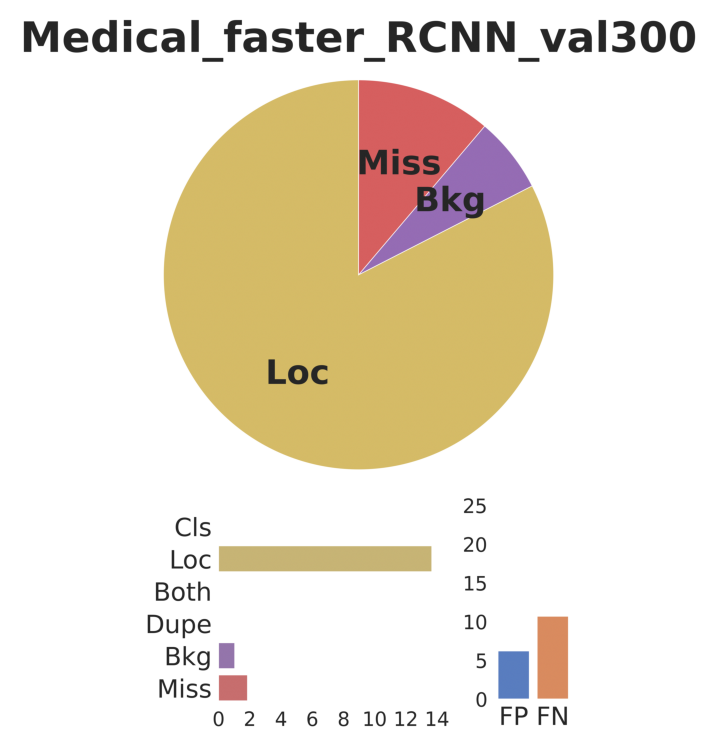

In [ ]:
tide = TIDE()
tide.evaluate(COCO('/content/drive/MyDrive/BSc_Project/Main_code_folder/TIMOTHY/val_300.json'), datasets.COCOResult('Medical_faster_RCNN_val300.json'), mode=TIDE.BOX) # Use TIDE.MASK for masks
tide.summarize()  # Summarize the results as tables in the console
tide.get_all_errors()
tide.plot()